In [95]:
#importing libraries
#reference : https://arxiv.org/pdf/1409.3215.pdf


import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import helpers

tf.reset_default_graph()



In [96]:
#some hyper parameters

encoder_vocab_size = 100  # suppose our encoding data vocab size is 100 
decoder_vocab_size = 150  # and decoding data vocab size is 150

batch_size=10

encoder_hidden_unit = 100
decoder_hidden_unit = 100

encoder_embedding_dim=50
decoder_embedding_dim=50


In [97]:
#inputs :  encoder_input , decoder_input , decoder_target


encoder_input = tf.placeholder(name='encoder_input',shape=[None,None],dtype=tf.int32)
decoder_input = tf.placeholder(name='decoder_input',shape=[None,None],dtype=tf.int32)
decoder_target= tf.placeholder(name='decoder_target',shape=[None,None],dtype=tf.int32)

#ecoder input should be  [Max_time,batch]  time major  
#decoder input should be [Max_time,batch]  time major
#decoder_target should be [Max_time,batch] time major
print(encoder_input)

Tensor("encoder_input:0", shape=(?, ?), dtype=int32)


In [98]:
#embedding for encoder , decoder



#use tf.get_variable instead of tf.Variable
encoder_embedding = tf.get_variable(name='encoder_embedding',
                                    shape=[encoder_vocab_size,encoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

decoder_embedding = tf.get_variable(name='decoder_embedding',
                                    shape=[decoder_vocab_size,decoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

embedd_encoder = tf.nn.embedding_lookup(encoder_embedding,encoder_input)
#now encoder input will become [ max_time , batch_size , embedding_dim ]

embedd_decoder = tf.nn.embedding_lookup(decoder_embedding,decoder_input)
#now decoder input will become [ max_time , batch_size , embedding_dim ]

print(embedd_encoder)

Tensor("embedding_lookup:0", shape=(?, ?, 50), dtype=float32)


In [99]:
#cell for rnn

encoder_cell = rnn.LSTMCell(num_units=encoder_hidden_unit)
decoder_cell = rnn.LSTMCell(num_units=decoder_hidden_unit)

In [100]:
#encoder

encoder_model, encoder_last_state = tf.nn.dynamic_rnn(cell=encoder_cell,
                                                      inputs=embedd_encoder,
                                                      time_major=True,
                                                      dtype=tf.float32)

In [101]:
#decoder 
decoder_output,decoder_last_state= tf.nn.dynamic_rnn(cell=decoder_cell,
                                                     inputs=embedd_decoder,
                                                     time_major=True,
                                                     initial_state=encoder_last_state,
                                                     dtype=tf.float32,
                                                     scope='decoder_inputs')


In [102]:
#projection layer without activation

linear_projection = tf.contrib.layers.fully_connected(decoder_output,decoder_vocab_size)


#taking max argument
prediction = tf.argmax(linear_projection,2)


In [103]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_target,
                                                     depth=decoder_vocab_size,dtype=tf.float32),
                                                     logits=linear_projection)

#reduce_mean
loss=tf.reduce_mean(cross_entropy)

#our aim is to minimize this loss


In [104]:
train = tf.train.AdamOptimizer().minimize(loss)

In [86]:
# #let's check network

# #make sure your encoder and decoder input and decoder taget batch size is same , time_stamps can be differ but batch_size
# #should be same otherwise you will get dim mismatch Error

# #fake data
# encoder_input_ = np.random.randint(0,10,[5,3])  #time major  [max_time , batch]
# print("encoder_input \n",encoder_input_)

# decoder_input_ = np.random.randint(0,10,[4,3])  #time_major  [max_time , batch]
# print("decoder_input \n",decoder_input_)

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     prediction_data = sess.run(prediction,feed_dict={encoder_input:encoder_input_,decoder_input:decoder_input_})
#     print("prediction_data \n",prediction_data)

encoder_input 
 [[7 2 3]
 [4 4 2]
 [3 1 1]
 [3 0 4]
 [1 5 1]]
decoder_input 
 [[7 2 6]
 [4 6 6]
 [5 3 0]
 [8 4 9]]
prediction_data 
 [[ 45  50  15]
 [111  50  15]
 [111  50  17]
 [  6 111  15]]


In [106]:
batch_size = 100

PAD = 0
EOS = 1
batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_input: encoder_inputs_,
        decoder_input: decoder_inputs_,
        decoder_target: decoder_targets_,
    }

max_batches = 3001
batches_in_epoch = 1000
loss_track = []



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_input].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()


batch 0
  minibatch loss: 5.005568504333496
  sample 1:
    input     > [7 9 6 8 4 0 0 0]
    predicted > [6 6 5 5 5 0 0 0 0]
  sample 2:
    input     > [6 2 8 0 0 0 0 0]
    predicted > [6 6 6 5 5 0 0 0 0]
  sample 3:
    input     > [2 4 2 6 9 8 3 0]
    predicted > [6 6 6 6 6 5 5 5 5]

batch 1000
  minibatch loss: 1.1616154909133911
  sample 1:
    input     > [6 3 7 8 2 7 9 0]
    predicted > [7 7 7 7 7 7 7 1 0]
  sample 2:
    input     > [2 3 7 9 9 0 0 0]
    predicted > [7 7 7 7 7 1 0 0 0]
  sample 3:
    input     > [7 5 3 0 0 0 0 0]
    predicted > [2 4 3 1 0 0 0 0 0]

batch 2000
  minibatch loss: 0.19712510704994202
  sample 1:
    input     > [5 2 4 8 0 0 0 0]
    predicted > [5 2 4 8 1 0 0 0 0]
  sample 2:
    input     > [8 8 7 9 9 2 2 5]
    predicted > [8 8 7 9 8 2 2 5 1]
  sample 3:
    input     > [4 6 5 8 9 5 0 0]
    predicted > [4 6 9 8 9 5 1 0 0]

batch 3000
  minibatch loss: 0.059102702885866165
  sample 1:
    input     > [7 2 6 3 5 5 9 0]
    predicted > [7 2 6

loss 0.0657 after 300100 examples (batch_size=100)


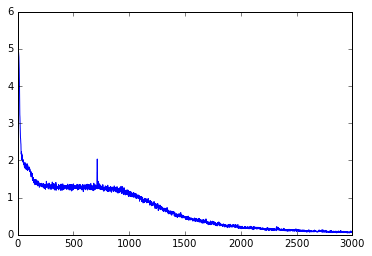

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))